In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import plotly.offline as py
import seaborn as sn
import requests
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.core.display import HTML
from sklearn import datasets
from dython.nominal import associations
import prince
from IPython.display import Image

<h1>Explicacion del despliegue<h1>


Para lograr determinar cuáles y cuántos son los usuarios en el sitio que están siendo afectados por los eventos que tomaron lugar en distintas horas del día, se usó un algoritmo de clasificacion simple. Dado que se quiere el catálogo exacto de los usuarios afectados, no se podía usar un algoritmo de clasificación o de predicción típicos de Machine Learning, pues daría resultados erroneos, asignando usuarios que no fueron afectados dentro se conjuntos de campañas.

El análisis se desarrolló en el notebook llamado "analisis.ipynb", el cual no tiene más de 30 lineas de código y que corre bajo la siguiente premisa:
<ol>
<li>El único parámetro clave en el set de datos es la columna de la fecha, las columnas de las horas, minutos y demas son obsoletas para el analisis</li>
</ol>


Teniendo esto en mente, el algoritmo de clasificación fue facil de hacer: se analizó entre el set de datos cuales fechas registradas en las estadisticas de la empresa estaban dentro del rango de tiempo (tiempo final - tiempo inicial) de los distintos eventos lanzados. 


Dicho rango fue siempre de 15 segundos, pero para que el analisis sea tan fiel a la realidad como se pueda, aquel que vaya a compilar el codigo será libre de escoger una ventana de tiempo adicional que se le agregará a los 15 segundos, pues no inmediatamente cuando vemos un add (peronalmente, tengo razones para creer que los eventos fueron simplemente adds lanzados en varias plataformas como Facebook, Instagram, Snap u otras) procedemos a instalar la aplicación a la que se nos fue re-dirigida hacia la appstore, pues nos toma un tiempo mientras miramos comentarios y reseñas acerca de si vale la pena o no instalarla.


No importa que valor se le haya dado a dicha ventana (el imput es en segundos), para cada evento el algoritmo se demora aproximadamente 1 minuto en encontrar a los usuarios que tuvieron alguna actividad durante su lanzamiento y asignarles el nombre del evento, dando asi un total de $\frac{268}{3}\approx 4.5$ horas, para luego escribir un archivo llamdo "treated.csv" con exactamente los mismos datos más la clisificación acabada de hacer. Cabe aclarar que dicho tiempo de computaciún se tomó sin hacer paralelización, es decir, corriendo a un solo nucleo el código. 

En el desplome que sigue, dicha ventana fue de solamente un segundo, con el fin de mostrar estadisticas "crudas", somo si fuese un robot automatizado quien hiciese esto.

Ahora, estamos listos para comenzar con las estadisticas. 



### ¿Que es y como se ve el impacto de las campañas lanzadas en la empresa?

Para responder a esta pregunta, comenzaremos con una visualizacion simple de cúantos y cúales fueron los usuarios que se vieron afectados por determinada campaña, la cual se es libre de escoger seleccionando su nombre en la casilla o simplemente borrando y escribiendo el nombre de la campaña (La campaña como defecto es la C):

In [19]:
data = pd.read_csv('treated.csv') 
data.drop('Unnamed: 0', axis = 1, inplace= True)
data['event_name']=data['event_name'].replace('NN',np.nan)
data.rename(columns={'event_name': 'Event'}, inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
lis=data['Event'].value_counts().index.tolist()

In [20]:
def show_clients(Event):
    n=str(Event)
    data2=data[['clientID','Event']]
    nu=data2.loc[data2['Event'] == n ]
#    nueva.drop('event_name', axis = 1,inplace= True) #comentar, aoarece advertencia

    display(HTML("<div style = 'background-color: #504e4e; padding: 30px '>" +
             "<span style='color: #fff; font-size:30px;'> Numero de usuarios: "  + str(int(data2.groupby('Event').count().loc[str(n)])) +
             "</div>")
       )
    print(nu['clientID'])
interact(show_clients, Event=widgets.Combobox(options=lis, value="C"))

interactive(children=(Combobox(value='C', description='Event', options=('BB', 'B', 'Z', 'DD', 'A', 'R', 'Y', '…

<function __main__.show_clients(Event)>

### ¿Cúal es la proporción entre las campañas?

Comenzaremos diciendo que de aqui en adelante, solo se tuvieron en cuenta el set de usuarios a los que se le asigno una campaña, pues de lo contrario, en las gráficas siguientes no se podría disernir el impacto de estas sobre la actividad en la pagina web.


La primera grafica a mostrar, como el titulo de la subsección lo dice, es la proporción que hay entre el numero de usuarios afectados de las campañas, teniendo la delantera con $\approx 20 \%=630$ de usuarios la campaña "BB" y quedando de últimas con $\approx 1 \%=35$ de usuarios la campaña "E"

In [21]:
labels=data['Event'].value_counts().index
values=data['Event'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text='Events',
annotations=[dict(text='Events',font_size=18, showarrow=False)])

### ¿Cómo son las estadísticas dentro de cada conjunto de usuarios de cierta campaña?

Como mirar proporciones es una de las formas más comunes y más faciles de mirar la estadistica de los datos, aquel que tenga en su poder este dashboard será libre de navegar por las campañas y variables (columnas) para así sacar sus propias conclusiones. Se muestra el registro del WIFI para la campaña "C"

In [22]:
def show_pie(Event,Column):
    n=str(Event)
    col=str(Column)
    gb = data.groupby(['Event'])
    groupe=gb.get_group(n)
    labels=groupe[col].value_counts().index
    values=groupe[col].value_counts().values
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
    fig.update_layout(title_text=col,
    annotations=[dict(text=col,font_size=18, showarrow=False)])
    fig.show()
interact(show_pie, Column=widgets.Combobox(options=data.columns.tolist(), value="WIFI"),Event=widgets.Combobox(options=lis, value="C"))

interactive(children=(Combobox(value='C', description='Event', options=('BB', 'B', 'Z', 'DD', 'A', 'R', 'Y', '…

<function __main__.show_pie(Event, Column)>

### ¿Cómo están correlacionados los datos?

Digamos que queremos ver que parametros (columnas) tienen el mayor impacto sobre lo que realmente importa: la acción que tuvo el usuario en la pagina web.

Esto lo podemos hacer de dos formas, mirar las correlaciones que hay entre todo el set de tados consigo mismo, o mirar las correlaciones dentro de cada sub-grupo formado por cada campaña.

Lo siguiente se desarrolló para la 2da opción, pues como se expicará al final, de cierta forma sale mejor considerar este caso que el general

In [23]:
def corr_group(Event):
    n=str(Event)
    filtered = data.groupby(['Event'])
    df_event=filtered.get_group(n)
    df=df_event.copy()
    df.drop(['Unnamed: 0.1','clientID','Keyword','Event','Country_Code',
             'Minute','Hour'], axis = 1, inplace= True)
    associations(df, nominal_columns='auto', mark_columns=False, 
                 theil_u=True, plot=True, clustering=False, 
                 bias_correction=False, nan_strategy='replace', 
                 nan_replace_value='NN', ax=None, figsize=(13,13), 
                 annot=True, fmt='.2f', cmap=None, sv_color='silver')
interact(corr_group,Event=widgets.Combobox(options=lis, value="C"))

interactive(children=(Combobox(value='C', description='Event', options=('BB', 'B', 'Z', 'DD', 'A', 'R', 'Y', '…

<function __main__.corr_group(Event)>

### ¿Cómo leo yo estos datos?

Para saber que tanto influye un parámetro sobre alguno otro, solo hay que pararse en un cuadro y mirar hacia la izquierda y la derecha: El de la derecha me dice el que esta influenciando al de abajo, y entre mas claro sea el color de la casilla, más influenia tiene. Así, si la casilla es de color piel suave y tiene un 1 en ella, significa que si sabemos el valor de la caracteristica de la izquierda, tendremos por seguro el valor de la caracteristica del piso, mientras que entre mas oscura sea, menos podremos decir que sabiendo el valor de la izquierda, se tendrá el de abajo.

Asi que, en conclusión, dado que lo que nos interesa es como podemos aumentar las instalaciones o primeras ordenes en cierta campaña, pues decir que sólo mirando la caracteristica "Device_Category" tendriamos una muy buena probabilidad de decir si cierto cliente va a instalar o a hacer su primera orden. Claro que considerando más variables como "Date" o "WIFI" nuestra prediccion se volvería mas robusta.


### ¿Es valido decir siempre que con tan poco parámetros seríamos capaces de predecir cuál será la accion del usuario?

Para responder esta pregunta tenemos esta vez que mirar no la matriz de correlación de cada grupo de campañas por separado, sino mas bien mirar las correlacones que hay entre todos los datos consigo mismos, sin ningun tipo de filtro.

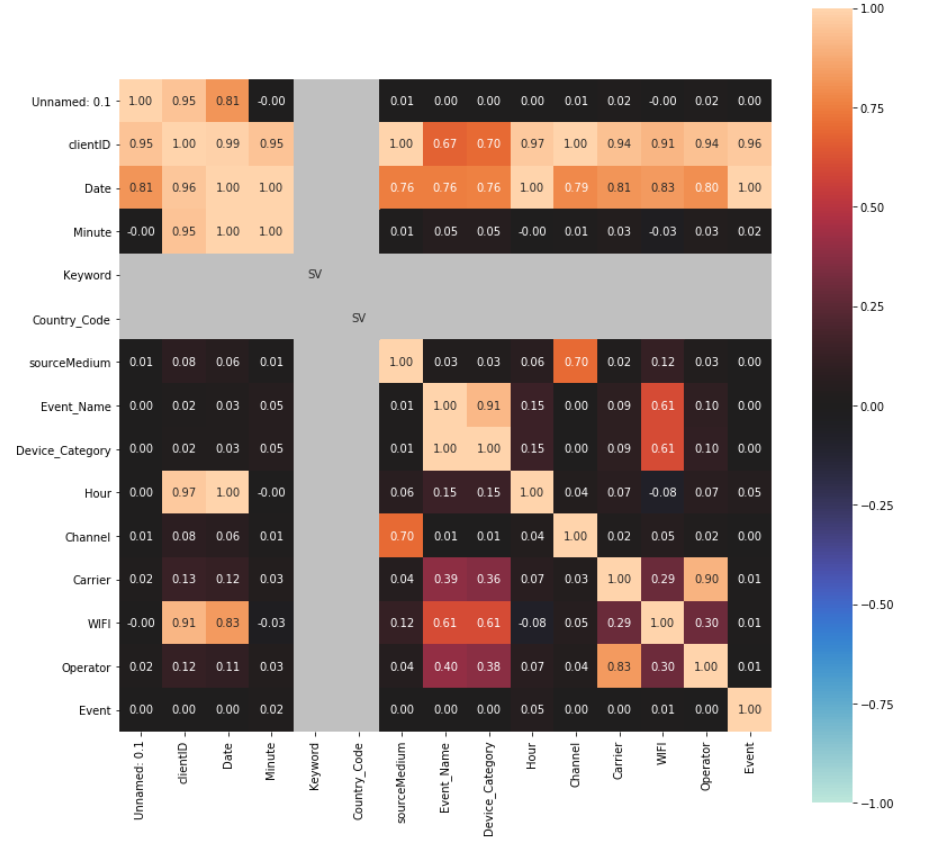

In [24]:
#Descomentar si se quiere graficar la matriz. Tiempo estimado: media hora 
#data.drop('Unnamed: 0', axis = 1, inplace= True)
#associations(data, nominal_columns='auto', mark_columns=False, theil_u=True, plot=True, clustering=False, bias_correction=False, nan_strategy='replace', nan_replace_value='NN', ax=None, figsize=(13,13), annot=True, fmt='.2f', cmap=None, sv_color='silver')
Image(filename='corr.png') #si se desomenta lo de arriba, comentar eso

Es mas que evidente que si nos paramos en las filas "Device_Category", "clientID" y "date" y fuesemos a mirar la columna "Event_Name", nuestra hipotesis de que sabiendo unas pocas variables podríamos predecir la accionen a pagina web, se fortalece.

Pero, de nuevo, hay variables que estan contenidas dentro de otras, como la hora y el minuto dentro de la fecha. Eliminando dichas variables, quedarpiamos con el siguiente gráfico:


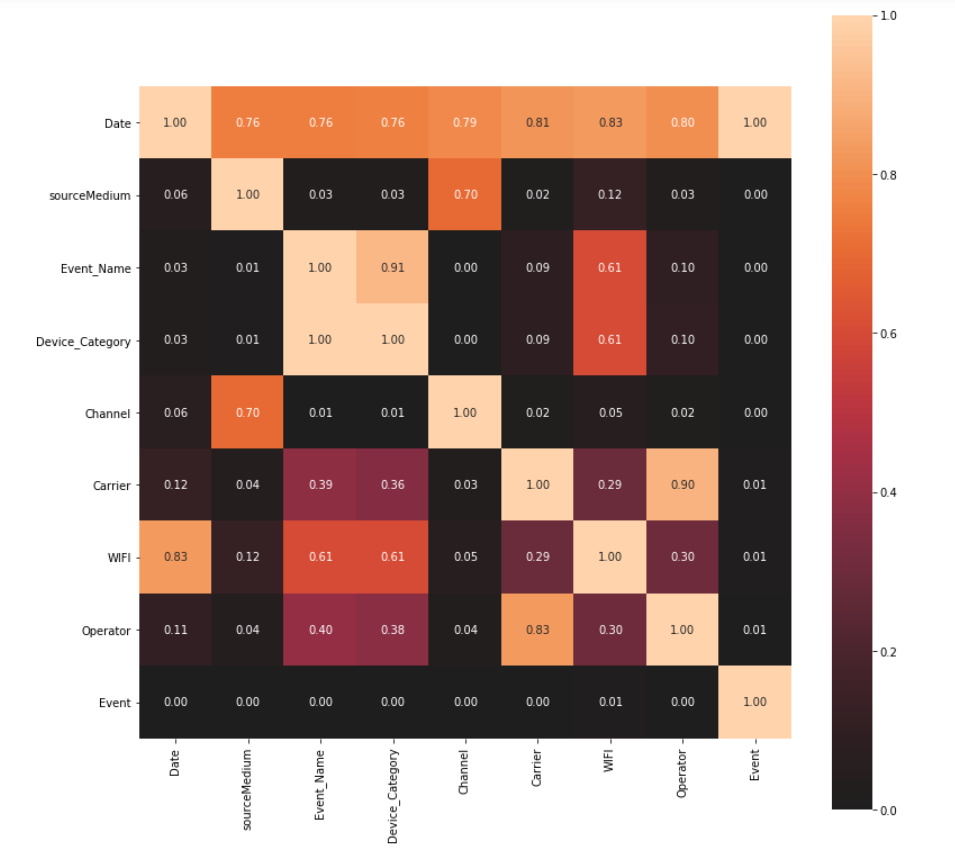

In [25]:
#Descomentar si se quiere graficar ma matriz, para parámetros sin repetir.
#Tiempo estimado: media hora
#data = pd.read_csv('treated.csv')
#data.drop(['Unnamed: 0.1','clientID','Keyword','Country_Code','Minute','Hour'], axis = 1, inplace= True)
#associations(data, nominal_columns='auto', mark_columns=False, theil_u=True, plot=True, clustering=False, bias_correction=False, nan_strategy='replace', nan_replace_value='NN', ax=None, figsize=(13,13), annot=True, fmt='.2f', cmap=None, sv_color='silver')
Image(filename='corr_filt.png')

Cabe aclarar que la columna "Event", la cual corresponde a las campañas lanzadas, no tiene ningun efecto considerable en la acción de los usuarios. ¿Por qué? porque la pagina web registró cientos de miles de datos, comparado con 14 campañas desplegadas que en conjunto fueron 258 datos, sumando no mas de 70 minutos de despliegue en total, mientras que los datos recopilados en la pagina web fueron durante un periodo de 10 días (recopilados en ese periodo, no que duren 10 días en toal) dando mas de 600.000 datos. La estadistica de las campañas desplegadas vs la de los datos obtenidos de la pagina web tienen un desfase inmenso.

### Limitaiones del modelo/ ¿Que más podríamos hacer?

1. Tiempo se procesamiento del modelo de clasificacion: 
    Dado que para analisar los datos de los usuarios teniendo en cuenta un solo registro de campaña toma en promedio un minuto, clasificar todo el set de campañas sin una paralelización se vuelve un poco tedioso.
    
2. No se profundizo respecto a categorias dentro de grupos formados provenientes de cada campaña (por ejemplo, en determinado lapso de tiempo, digamos media hora, cúantas instalaciones, y mejor aún, cuántos nuevos pedidos hubieron y cuántos de ellos le correspondieron a la campaña), con más recursos, mas tiempo y un modelo de predicción, se sería capaz de decir a qué hora o lapso de tiempo hay mas instalaciones o primeras ordenes, así la compañía puede lanzar la campaña que mas le convenga para aumentar ambas y mejorar aún más su producción.